# Pretrained Vectors - Dot Product

We train traditional (non neural network) classifiers from Scikit-Learn by looking up the vectors for each given image pair. These image vectors were [generated using pre-trained networks from Keras Model Zoo](http://localhost:8888/notebooks/pretrained-nets-vectorizers.ipynb). In this notebook, we merge the vectors for the image pair by calculating their element-wise dot product normalized by the L2 norms of the two vectors.

In [1]:
from __future__ import division, print_function
from sklearn.ensemble import RandomForestClassifier
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import itertools
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline

In [2]:
DATA_DIR = "../data"
IMAGE_DIR = os.path.join(DATA_DIR, "holiday-photos")

In [3]:
def get_holiday_triples(image_dir):
    image_groups = {}
    for image_name in os.listdir(image_dir):
        base_name = image_name[0:-4]
        group_name = base_name[0:4]
        if image_groups.has_key(group_name):
            image_groups[group_name].append(image_name)
        else:
            image_groups[group_name] = [image_name]
    num_sims = 0
    image_triples = []
    group_list = sorted(list(image_groups.keys()))
    for i, g in enumerate(group_list):
        if num_sims % 100 == 0:
            print("Generated {:d} pos + {:d} neg = {:d} total image triples"
                  .format(num_sims, num_sims, 2*num_sims))
        images_in_group = image_groups[g]
        sim_pairs_it = itertools.combinations(images_in_group, 2)
        # for each similar pair, generate a corresponding different pair
        for ref_image, sim_image in sim_pairs_it:
            image_triples.append((ref_image, sim_image, 1))
            num_sims += 1
            while True:
                j = np.random.randint(low=0, high=len(group_list), size=1)[0]
                if j != i:
                    break
            dif_image_candidates = image_groups[group_list[j]]
            k = np.random.randint(low=0, high=len(dif_image_candidates), size=1)[0]
            dif_image = dif_image_candidates[k]
            image_triples.append((ref_image, dif_image, 0))
    print("Generated {:d} pos + {:d} neg = {:d} total image triples"
          .format(num_sims, num_sims, 2*num_sims))
    return image_triples

def load_vectors(vector_file):
    vec_dict = {}
    fvec = open(vector_file, "rb")
    for line in fvec:
        image_name, image_vec = line.strip().split("\t")
        vec = np.array([float(v) for v in image_vec.split(",")])
        vec_dict[image_name] = vec
    fvec.close()
    return vec_dict

def preprocess_data(vector_file, train_size=0.7):
    xdata, ydata = [], []
    vec_dict = load_vectors(vector_file)
    for image_triple in image_triples:
        X1 = vec_dict[image_triple[0]]
        X2 = vec_dict[image_triple[1]]
        xdata.append(np.multiply(X1, X2) / (np.linalg.norm(X1, 2) * np.linalg.norm(X2, 2)))
        ydata.append(image_triple[2])
    X, y = np.array(xdata), np.array(ydata)
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    return Xtrain, Xtest, ytrain, ytest

def cross_validate(X, y, clf, k=10):
    best_score, best_clf = 0.0, None
    kfold = KFold(k)
    for kid, (train, test) in enumerate(kfold.split(X, y)):
        Xtrain, Xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
        clf.fit(Xtrain, ytrain)
        ytest_ = clf.predict(Xtest)
        score = accuracy_score(ytest_, ytest)
        print("fold {:d}, score: {:.3f}".format(kid, score))
        if score > best_score:
            best_score = score
            best_clf = clf
    return best_clf, best_score

def test_report(clf, Xtest, ytest):
    ytest_ = clf.predict(Xtest)
    print("\nAccuracy Score: {:.3f}".format(accuracy_score(ytest_, ytest)))
    print("\nConfusion Matrix")
    print(confusion_matrix(ytest_, ytest))
    print("\nClassification Report")
    print(classification_report(ytest_, ytest))
    
def get_model_file(data_dir, vec_name, clf_name):
    return os.path.join(data_dir, "models", "{:s}-{:s}-dot.pkl"
                        .format(vec_name, clf_name))

def save_model(model, model_file):
    joblib.dump(model, model_file)

In [4]:
image_triples = get_holiday_triples(IMAGE_DIR)

Generated 0 pos + 0 neg = 0 total image triples
Generated 300 pos + 300 neg = 600 total image triples
Generated 1100 pos + 1100 neg = 2200 total image triples
Generated 1800 pos + 1800 neg = 3600 total image triples
Generated 2072 pos + 2072 neg = 4144 total image triples


In [5]:
NUM_VECTORIZERS = 5
NUM_CLASSIFIERS = 4
scores = np.zeros((NUM_VECTORIZERS, NUM_CLASSIFIERS))

# VGG-16 Vectors

In [6]:
VECTOR_FILE = os.path.join(DATA_DIR, "vgg16-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 4096) (1244, 4096) (2900,) (1244,)


## Naive Bayes

In [7]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "nb"))

fold 0, score: 0.890
fold 1, score: 0.859
fold 2, score: 0.859
fold 3, score: 0.852
fold 4, score: 0.876
fold 5, score: 0.834
fold 6, score: 0.828
fold 7, score: 0.848
fold 8, score: 0.848
fold 9, score: 0.859

Accuracy Score: 0.847

Confusion Matrix
[[542 117]
 [ 73 512]]

Classification Report
             precision    recall  f1-score   support

          0       0.88      0.82      0.85       659
          1       0.81      0.88      0.84       585

avg / total       0.85      0.85      0.85      1244



## SVM

In [8]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "svm"))

fold 0, score: 0.852
fold 1, score: 0.817
fold 2, score: 0.797
fold 3, score: 0.797
fold 4, score: 0.772
fold 5, score: 0.807
fold 6, score: 0.814
fold 7, score: 0.831
fold 8, score: 0.786
fold 9, score: 0.728

Accuracy Score: 0.805

Confusion Matrix
[[544 172]
 [ 71 457]]

Classification Report
             precision    recall  f1-score   support

          0       0.88      0.76      0.82       716
          1       0.73      0.87      0.79       528

avg / total       0.82      0.80      0.81      1244



## XGBoost

In [9]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "xgb"))

fold 0, score: 0.934
fold 1, score: 0.893
fold 2, score: 0.948
fold 3, score: 0.931
fold 4, score: 0.903
fold 5, score: 0.897
fold 6, score: 0.903
fold 7, score: 0.934
fold 8, score: 0.886
fold 9, score: 0.931

Accuracy Score: 0.917

Confusion Matrix
[[572  60]
 [ 43 569]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.91      0.92       632
          1       0.90      0.93      0.92       612

avg / total       0.92      0.92      0.92      1244



## Random Forest

In [10]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[0, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg16", "rf"))

fold 0, score: 0.893
fold 1, score: 0.862
fold 2, score: 0.886
fold 3, score: 0.872
fold 4, score: 0.879
fold 5, score: 0.866
fold 6, score: 0.879
fold 7, score: 0.876
fold 8, score: 0.817
fold 9, score: 0.845

Accuracy Score: 0.861

Confusion Matrix
[[568 126]
 [ 47 503]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.82      0.87       694
          1       0.80      0.91      0.85       550

avg / total       0.87      0.86      0.86      1244



# VGG-19

In [11]:
VECTOR_FILE = os.path.join(DATA_DIR, "vgg19-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 4096) (1244, 4096) (2900,) (1244,)


## Naive Bayes

In [12]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "nb"))

fold 0, score: 0.838
fold 1, score: 0.862
fold 2, score: 0.855
fold 3, score: 0.859
fold 4, score: 0.866
fold 5, score: 0.876
fold 6, score: 0.824
fold 7, score: 0.848
fold 8, score: 0.869
fold 9, score: 0.866

Accuracy Score: 0.841

Confusion Matrix
[[527 128]
 [ 70 519]]

Classification Report
             precision    recall  f1-score   support

          0       0.88      0.80      0.84       655
          1       0.80      0.88      0.84       589

avg / total       0.84      0.84      0.84      1244



## SVM

In [13]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "svm"))

fold 0, score: 0.741
fold 1, score: 0.831
fold 2, score: 0.786
fold 3, score: 0.783
fold 4, score: 0.766
fold 5, score: 0.755
fold 6, score: 0.810
fold 7, score: 0.766
fold 8, score: 0.834
fold 9, score: 0.800

Accuracy Score: 0.781

Confusion Matrix
[[545 220]
 [ 52 427]]

Classification Report
             precision    recall  f1-score   support

          0       0.91      0.71      0.80       765
          1       0.66      0.89      0.76       479

avg / total       0.82      0.78      0.78      1244



## XGBoost

In [14]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "xgb"))

fold 0, score: 0.903
fold 1, score: 0.934
fold 2, score: 0.910
fold 3, score: 0.924
fold 4, score: 0.931
fold 5, score: 0.893
fold 6, score: 0.893
fold 7, score: 0.910
fold 8, score: 0.941
fold 9, score: 0.931

Accuracy Score: 0.913

Confusion Matrix
[[563  74]
 [ 34 573]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.88      0.91       637
          1       0.89      0.94      0.91       607

avg / total       0.92      0.91      0.91      1244



## Random Forest

In [15]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[1, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "vgg19", "rf"))

fold 0, score: 0.841
fold 1, score: 0.907
fold 2, score: 0.890
fold 3, score: 0.855
fold 4, score: 0.879
fold 5, score: 0.845
fold 6, score: 0.848
fold 7, score: 0.900
fold 8, score: 0.897
fold 9, score: 0.900

Accuracy Score: 0.853

Confusion Matrix
[[552 138]
 [ 45 509]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.80      0.86       690
          1       0.79      0.92      0.85       554

avg / total       0.86      0.85      0.85      1244



# Inception V3

In [16]:
VECTOR_FILE = os.path.join(DATA_DIR, "inception-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 2048) (1244, 2048) (2900,) (1244,)


## Naive Bayes

In [17]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "nb"))

fold 0, score: 0.917
fold 1, score: 0.883
fold 2, score: 0.831
fold 3, score: 0.897
fold 4, score: 0.900
fold 5, score: 0.859
fold 6, score: 0.900
fold 7, score: 0.897
fold 8, score: 0.893
fold 9, score: 0.872

Accuracy Score: 0.883

Confusion Matrix
[[612 121]
 [ 24 487]]

Classification Report
             precision    recall  f1-score   support

          0       0.96      0.83      0.89       733
          1       0.80      0.95      0.87       511

avg / total       0.90      0.88      0.88      1244



## SVM

In [18]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "svm"))

fold 0, score: 0.817
fold 1, score: 0.859
fold 2, score: 0.852
fold 3, score: 0.876
fold 4, score: 0.845
fold 5, score: 0.841
fold 6, score: 0.869
fold 7, score: 0.797
fold 8, score: 0.828
fold 9, score: 0.866

Accuracy Score: 0.839

Confusion Matrix
[[498  62]
 [138 546]]

Classification Report
             precision    recall  f1-score   support

          0       0.78      0.89      0.83       560
          1       0.90      0.80      0.85       684

avg / total       0.85      0.84      0.84      1244



## XGBoost

In [19]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "xgb"))

fold 0, score: 0.959
fold 1, score: 0.941
fold 2, score: 0.938
fold 3, score: 0.962
fold 4, score: 0.928
fold 5, score: 0.952
fold 6, score: 0.966
fold 7, score: 0.959
fold 8, score: 0.952
fold 9, score: 0.952

Accuracy Score: 0.937

Confusion Matrix
[[593  35]
 [ 43 573]]

Classification Report
             precision    recall  f1-score   support

          0       0.93      0.94      0.94       628
          1       0.94      0.93      0.94       616

avg / total       0.94      0.94      0.94      1244



## Random Forest

In [20]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[2, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "inceptionv3", "rf"))

fold 0, score: 0.934
fold 1, score: 0.893
fold 2, score: 0.914
fold 3, score: 0.907
fold 4, score: 0.883
fold 5, score: 0.890
fold 6, score: 0.931
fold 7, score: 0.917
fold 8, score: 0.917
fold 9, score: 0.900

Accuracy Score: 0.891

Confusion Matrix
[[605 105]
 [ 31 503]]

Classification Report
             precision    recall  f1-score   support

          0       0.95      0.85      0.90       710
          1       0.83      0.94      0.88       534

avg / total       0.90      0.89      0.89      1244



# ResNet 50

In [21]:
VECTOR_FILE = os.path.join(DATA_DIR, "resnet-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 2048) (1244, 2048) (2900,) (1244,)


## Naive Bayes

In [22]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "nb"))

fold 0, score: 0.824
fold 1, score: 0.831
fold 2, score: 0.828
fold 3, score: 0.845
fold 4, score: 0.852
fold 5, score: 0.848
fold 6, score: 0.883
fold 7, score: 0.859
fold 8, score: 0.872
fold 9, score: 0.845

Accuracy Score: 0.863

Confusion Matrix
[[571 116]
 [ 54 503]]

Classification Report
             precision    recall  f1-score   support

          0       0.91      0.83      0.87       687
          1       0.81      0.90      0.86       557

avg / total       0.87      0.86      0.86      1244



## SVM

In [23]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "svm"))

fold 0, score: 0.869
fold 1, score: 0.824
fold 2, score: 0.834
fold 3, score: 0.869
fold 4, score: 0.838
fold 5, score: 0.852
fold 6, score: 0.838
fold 7, score: 0.793
fold 8, score: 0.831
fold 9, score: 0.824

Accuracy Score: 0.853

Confusion Matrix
[[587 145]
 [ 38 474]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.80      0.87       732
          1       0.77      0.93      0.84       512

avg / total       0.87      0.85      0.85      1244



## XGBoost

In [24]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "xgb"))

fold 0, score: 0.883
fold 1, score: 0.907
fold 2, score: 0.886
fold 3, score: 0.910
fold 4, score: 0.890
fold 5, score: 0.852
fold 6, score: 0.903
fold 7, score: 0.869
fold 8, score: 0.848
fold 9, score: 0.862

Accuracy Score: 0.879

Confusion Matrix
[[558  83]
 [ 67 536]]

Classification Report
             precision    recall  f1-score   support

          0       0.89      0.87      0.88       641
          1       0.87      0.89      0.88       603

avg / total       0.88      0.88      0.88      1244



## Random Forest

In [25]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[3, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "resnet50", "rf"))

fold 0, score: 0.838
fold 1, score: 0.879
fold 2, score: 0.824
fold 3, score: 0.845
fold 4, score: 0.876
fold 5, score: 0.841
fold 6, score: 0.876
fold 7, score: 0.834
fold 8, score: 0.776
fold 9, score: 0.848

Accuracy Score: 0.830

Confusion Matrix
[[546 132]
 [ 79 487]]

Classification Report
             precision    recall  f1-score   support

          0       0.87      0.81      0.84       678
          1       0.79      0.86      0.82       566

avg / total       0.83      0.83      0.83      1244



# Xception

In [26]:
VECTOR_FILE = os.path.join(DATA_DIR, "xception-vectors.tsv")
Xtrain, Xtest, ytrain, ytest = preprocess_data(VECTOR_FILE)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(2900, 2048) (1244, 2048) (2900,) (1244,)


## Naive Bayes

In [27]:
clf = GaussianNB()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 0] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "nb"))

fold 0, score: 0.914
fold 1, score: 0.917
fold 2, score: 0.917
fold 3, score: 0.931
fold 4, score: 0.924
fold 5, score: 0.910
fold 6, score: 0.903
fold 7, score: 0.907
fold 8, score: 0.924
fold 9, score: 0.907

Accuracy Score: 0.911

Confusion Matrix
[[590  71]
 [ 40 543]]

Classification Report
             precision    recall  f1-score   support

          0       0.94      0.89      0.91       661
          1       0.88      0.93      0.91       583

avg / total       0.91      0.91      0.91      1244



## SVM

In [28]:
clf = LinearSVC()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 1] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "svm"))

fold 0, score: 0.876
fold 1, score: 0.897
fold 2, score: 0.914
fold 3, score: 0.890
fold 4, score: 0.886
fold 5, score: 0.886
fold 6, score: 0.879
fold 7, score: 0.893
fold 8, score: 0.897
fold 9, score: 0.903

Accuracy Score: 0.890

Confusion Matrix
[[600 107]
 [ 30 507]]

Classification Report
             precision    recall  f1-score   support

          0       0.95      0.85      0.90       707
          1       0.83      0.94      0.88       537

avg / total       0.90      0.89      0.89      1244



## XGBoost

In [29]:
clf = XGBClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 2] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "xgb"))

fold 0, score: 0.897
fold 1, score: 0.883
fold 2, score: 0.903
fold 3, score: 0.886
fold 4, score: 0.879
fold 5, score: 0.859
fold 6, score: 0.900
fold 7, score: 0.879
fold 8, score: 0.862
fold 9, score: 0.866

Accuracy Score: 0.883

Confusion Matrix
[[580  95]
 [ 50 519]]

Classification Report
             precision    recall  f1-score   support

          0       0.92      0.86      0.89       675
          1       0.85      0.91      0.88       569

avg / total       0.89      0.88      0.88      1244



## Random Forest

In [30]:
clf = RandomForestClassifier()
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
scores[4, 3] = best_score
test_report(best_clf, Xtest, ytest)
save_model(best_clf, get_model_file(DATA_DIR, "xception", "rf"))

fold 0, score: 0.831
fold 1, score: 0.838
fold 2, score: 0.862
fold 3, score: 0.834
fold 4, score: 0.807
fold 5, score: 0.821
fold 6, score: 0.834
fold 7, score: 0.834
fold 8, score: 0.831
fold 9, score: 0.831

Accuracy Score: 0.830

Confusion Matrix
[[560 142]
 [ 70 472]]

Classification Report
             precision    recall  f1-score   support

          0       0.89      0.80      0.84       702
          1       0.77      0.87      0.82       542

avg / total       0.84      0.83      0.83      1244



In [31]:
scores

array([[ 0.88965517,  0.85172414,  0.94827586,  0.89310345],
       [ 0.87586207,  0.83448276,  0.94137931,  0.90689655],
       [ 0.91724138,  0.87586207,  0.96551724,  0.93448276],
       [ 0.88275862,  0.86896552,  0.91034483,  0.87931034],
       [ 0.93103448,  0.9137931 ,  0.90344828,  0.86206897]])

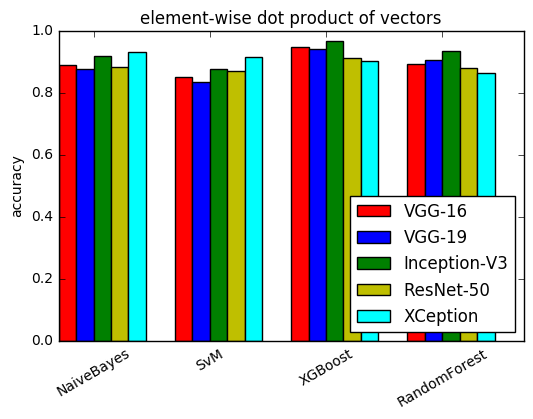

In [32]:
width=0.15
plt.bar(np.arange(NUM_CLASSIFIERS), scores[0], width, color="r", label="VGG-16")
plt.bar(np.arange(NUM_CLASSIFIERS)+width, scores[1], width, color="b", label="VGG-19")
plt.bar(np.arange(NUM_CLASSIFIERS)+2*width, scores[2], width, color="g", label="Inception-V3")
plt.bar(np.arange(NUM_CLASSIFIERS)+3*width, scores[3], width, color="y", label="ResNet-50")
plt.bar(np.arange(NUM_CLASSIFIERS)+4*width, scores[4], width, color="cyan", label="XCeption")
plt.legend(loc=4)
plt.ylabel("accuracy")
plt.xticks(np.arange(NUM_CLASSIFIERS)+2*width, ["NaiveBayes", "SvM", "XGBoost", "RandomForest"],
          rotation=30)
plt.title("element-wise dot product of vectors")